In [ ]:
pip install wget

## Dowloading CORD-19 data
Using this recipe: https://pyvespa.readthedocs.io/en/latest/use_cases/cord19/cord19_download_parse_trec_covid.html

In [40]:
import wget
from sentence_transformers import SentenceTransformer, util
import torch
import pandas as pd
import numpy as np
import seaborn as sns

C:\Users\User\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:526: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

C:\Users\User\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:527: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

C:\Users\User\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:528: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.

C:\Users\User\AppData\Local\Continuum\anaconda3\lib\site-packages\tensorflow\python\framework\dtypes.py:529: FutureWarning:

Passing (type, 1) or '1type' as a synonym of type is dep

Source of the relevance data:
https://ir.nist.gov/covidSubmit/data.html

In [4]:
url_xml = "https://ir.nist.gov/covidSubmit/data/topics-rnd5.xml"
filename_xml = wget.download(url_xml)

url_txt = "https://ir.nist.gov/covidSubmit/data/qrels-covid_d5_j0.5-5.txt"
filname_txt = wget.download(url_txt)



100% [..........................................................................] 1142244 / 1142244

In [5]:
import xml.etree.ElementTree as ET

topics = {}
root = ET.parse("topics-rnd5.xml").getroot()
for topic in root.findall("topic"):
    topic_number = topic.attrib["number"]
    topics[topic_number] = {}
    for query in topic.findall("query"):
        topics[topic_number]["query"] = query.text
    for question in topic.findall("question"):
        topics[topic_number]["question"] = question.text
    for narrative in topic.findall("narrative"):
        topics[topic_number]["narrative"] = narrative.text

In [9]:
print(len(topics))
topics["1"]



50


{'query': 'coronavirus origin',
 'question': 'what is the origin of COVID-19',
 'narrative': "seeking range of information about the SARS-CoV-2 virus's origin, including its evolution, animal source, and first transmission into humans"}

In [7]:
import pandas as pd

relevance_data = pd.read_csv("qrels-covid_d5_j0.5-5.txt", sep=" ", header=None)
relevance_data.columns = ["topic_id", "round_id", "cord_uid", "relevancy"]

In [8]:
relevance_data.head()

,topic_id,round_id,cord_uid,relevancy
0,1,4.5,005b2j4b,2
1,1,4.0,00fmeepz,1
2,1,0.5,010vptx3,2
3,1,2.5,0194oljo,1
4,1,4.0,021q9884,1


In [155]:
relevance_data_round5 = relevance_data[relevance_data["round_id"] == 5.0]

In [156]:
print(len(relevance_data_round5))

17195


In [153]:
relevance_data["round_id"].nunique()

10

In [157]:
print(len(relevance_data_round5))
relevance_data_round5["cord_uid"].nunique()

17195


13612

In [159]:
relevance_data[relevance_data.relevancy == -1]

,topic_id,round_id,cord_uid,relevancy


In [160]:
relevance_data = relevance_data[relevance_data.relevancy >= 0]

In [166]:
import plotly.express as px

fig = px.histogram(relevance_data, x="topic_id", color = "relevancy")
fig.show()

In [41]:
embedder = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')

# nli - trained on NLI (natural language interface) dataset
# stsb - trained on

In [55]:
n = len(topics)
query = [0 for _ in range(n)]
question = [0 for _ in range(n)]
narrative = [0 for _ in range(n)]

for i , topic in enumerate(topics):
    row = topics[topic]
    query[i] = row["query"]
    question[i] = row["question"]
    narrative[i] = row["narrative"]

query_embedding = embedder.encode(query, convert_to_tensor=True).cpu()
question_embedding = embedder.encode(question, convert_to_tensor=True).cpu()
narrative_embedding = embedder.encode(narrative, convert_to_tensor=True).cpu()

topics_df = pd.DataFrame({
    "query" : query,
    "question" : question,
    "narrative" : narrative,
    "query_embedding" : query_embedding,
    "question_embedding": question_embedding,
    "narrative_embedding" : narrative_embedding
})

topics_df.head()
    

,query,question,narrative,query_embedding,question_embedding,narrative_embedding
0,coronavirus origin,what is the origin of COVID-19,seeking range of information about the SARS-Co...,"(tensor(0.6907), tensor(-0.6641), tensor(-0.29...","(tensor(0.3336), tensor(-0.1007), tensor(0.272...","(tensor(0.2207), tensor(-0.3513), tensor(-0.47..."
1,coronavirus response to weather changes,how does the coronavirus respond to changes in...,seeking range of information about the SARS-Co...,"(tensor(0.3753), tensor(-0.7276), tensor(0.409...","(tensor(0.4442), tensor(-0.6221), tensor(0.116...","(tensor(0.3033), tensor(-0.6226), tensor(-0.15..."
2,coronavirus immunity,will SARS-CoV2 infected people develop immunit...,seeking studies of immunity developed due to i...,"(tensor(0.2238), tensor(-0.6091), tensor(-0.13...","(tensor(0.0033), tensor(-0.5361), tensor(0.058...","(tensor(0.1273), tensor(-0.4348), tensor(0.365..."
3,how do people die from the coronavirus,what causes death from Covid-19?,Studies looking at mechanisms of death from Co...,"(tensor(1.3396), tensor(-0.6236), tensor(-0.19...","(tensor(0.2422), tensor(-0.1231), tensor(0.572...","(tensor(0.2918), tensor(-0.7164), tensor(0.552..."
4,animal models of COVID-19,what drugs have been active against SARS-CoV o...,Papers that describe the results of testing d...,"(tensor(0.0310), tensor(-0.2309), tensor(0.470...","(tensor(-0.1455), tensor(-0.7728), tensor(-0.7...","(tensor(-0.1099), tensor(-0.4158), tensor(0.56..."


In [49]:
query_question_cos = util.pytorch_cos_sim(topics_df["query_embedding"], topics_df["question_embedding"])
query_narrative_cos = util.pytorch_cos_sim(topics_df["query_embedding"], topics_df["narrative_embedding"])
question_narrative_cos = util.pytorch_cos_sim(topics_df["question_embedding"], topics_df["narrative_embedding"])

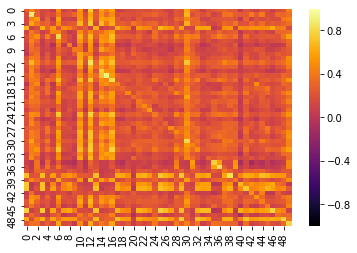

In [50]:
sns.heatmap(query_question_cos, vmin = -1, vmax = 1, cmap="inferno")

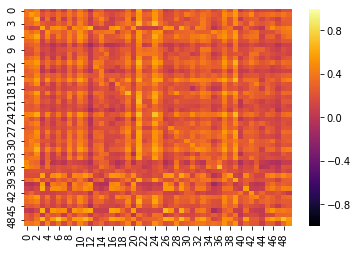

In [51]:
sns.heatmap(query_narrative_cos, vmin = -1, vmax = 1, cmap="inferno")

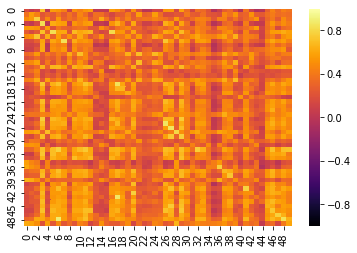

In [52]:
sns.heatmap(question_narrative_cos, vmin = -1, vmax = 1, cmap="inferno")

In [164]:
path_metadata = "C:\\Users\\User\\OneDrive - NTNU\\NTNU\\Prosjekt oppgave NLP\\dataset\\CORD-19\\metadata\\"
file = "metadata.csv"

metadata_pd = pd.read_csv(path_metadata + file)


KeyboardInterrupt: 

In [165]:

print(len(metadata_pd))
print(metadata_pd["cord_uid"].nunique())

metadata_pd.head()

301667
287145


,cord_uid,sha,source_x,title,doi,pmcid,pubmed_id,license,abstract,publish_time,authors,journal,mag_id,who_covidence_id,arxiv_id,pdf_json_files,pmc_json_files,url,s2_id
0,ug7v899j,d1aafb70c066a2068b02786f8929fd9c900897fb,PMC,Clinical features of culture-proven Mycoplasma...,10.1186/1471-2334-1-6,PMC35282,11472636,no-cc,OBJECTIVE: This retrospective chart review des...,2001-07-04,"Madani, Tariq A; Al-Ghamdi, Aisha A",BMC Infect Dis,NaN,NaN,NaN,document_parses/pdf_json/d1aafb70c066a2068b027...,document_parses/pmc_json/PMC35282.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3...,NaN
1,02tnwd4m,6b0567729c2143a66d737eb0a2f63f2dce2e5a7d,PMC,Nitric oxide: a pro-inflammatory mediator in l...,10.1186/rr14,PMC59543,11667967,no-cc,Inflammatory diseases of the respiratory tract...,2000-08-15,"Vliet, Albert van der; Eiserich, Jason P; Cros...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/6b0567729c2143a66d737...,document_parses/pmc_json/PMC59543.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
2,ejv2xln0,06ced00a5fc04215949aa72528f2eeaae1d58927,PMC,Surfactant protein-D and pulmonary host defense,10.1186/rr19,PMC59549,11667972,no-cc,Surfactant protein-D (SP-D) participates in th...,2000-08-25,"Crouch, Erika C",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/06ced00a5fc04215949aa...,document_parses/pmc_json/PMC59549.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
3,2b73a28n,348055649b6b8cf2b9a376498df9bf41f7123605,PMC,Role of endothelin-1 in lung disease,10.1186/rr44,PMC59574,11686871,no-cc,Endothelin-1 (ET-1) is a 21 amino acid peptide...,2001-02-22,"Fagan, Karen A; McMurtry, Ivan F; Rodman, David M",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/348055649b6b8cf2b9a37...,document_parses/pmc_json/PMC59574.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN
4,9785vg6d,5f48792a5fa08bed9f56016f4981ae2ca6031b32,PMC,Gene expression in epithelial cells in respons...,10.1186/rr61,PMC59580,11686888,no-cc,Respiratory syncytial virus (RSV) and pneumoni...,2001-05-11,"Domachowske, Joseph B; Bonville, Cynthia A; Ro...",Respir Res,NaN,NaN,NaN,document_parses/pdf_json/5f48792a5fa08bed9f560...,document_parses/pmc_json/PMC59580.xml.json,https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5...,NaN


In [65]:
metadata_red_pd = metadata_pd[["cord_uid", "title", "abstract"]]
metadata_red_pd.head()

,cord_uid,title,abstract
0,ug7v899j,Clinical features of culture-proven Mycoplasma...,OBJECTIVE: This retrospective chart review des...
1,02tnwd4m,Nitric oxide: a pro-inflammatory mediator in l...,Inflammatory diseases of the respiratory tract...
2,ejv2xln0,Surfactant protein-D and pulmonary host defense,Surfactant protein-D (SP-D) participates in th...
3,2b73a28n,Role of endothelin-1 in lung disease,Endothelin-1 (ET-1) is a 21 amino acid peptide...
4,9785vg6d,Gene expression in epithelial cells in respons...,Respiratory syncytial virus (RSV) and pneumoni...


In [66]:
len(metadata_red_pd)

301667

In [141]:
metadata_red_pd = metadata_red_pd[metadata_red_pd["abstract"].notna()]
print(len(metadata_red_pd))
metadata_sample = metadata_red_pd.sample(n=200, replace=False, random_state = 10)
metadata_sample.head()

214463


,cord_uid,title,abstract
236216,36el91lg,Managing patients with rheumatic diseases duri...,Abstract Background: Rheumatologists must cont...
11342,k2kca8zl,Benefit-to-risk balance of bronchoalveolar lav...,PURPOSE: To assess the benefit-to-risk balance...
35434,6h34q3bh,Dynamic article: long-term outcomes of patient...,BACKGROUND Patients with large benign colon po...
115804,otyw5b77,Systemic risk: The impact of COVID-19,Banking sectors across the globe are under imm...
34005,3qlg8uhb,Safe endobag morcellation in a single-port lap...,"Recently, the American Food and Drug Administr..."


In [143]:
n = len(metadata_sample)

title = [0 for _ in range(n)]
abstract = [0 for _ in range(n)]
i = 0
for idx, row in metadata_sample.iterrows():
    title[i] = row["title"]
    abstract[i] = row["abstract"]
    i += 1

title_embedding = embedder.encode(title, convert_to_tensor=True).cpu()
abstract_embedding = embedder.encode(abstract, convert_to_tensor=True).cpu()

metadata_sample["title_embedding"] = title_embedding
metadata_sample["abstract_embedding"] = abstract_embedding

In [144]:
metadata_sample.head()

,cord_uid,title,abstract,title_embedding,abstract_embedding
236216,36el91lg,Managing patients with rheumatic diseases duri...,Abstract Background: Rheumatologists must cont...,"(tensor(0.2900), tensor(-0.1433), tensor(0.270...","(tensor(0.6408), tensor(0.2778), tensor(0.4034..."
11342,k2kca8zl,Benefit-to-risk balance of bronchoalveolar lav...,PURPOSE: To assess the benefit-to-risk balance...,"(tensor(0.1883), tensor(-0.3107), tensor(0.783...","(tensor(0.3183), tensor(0.0127), tensor(0.8379..."
35434,6h34q3bh,Dynamic article: long-term outcomes of patient...,BACKGROUND Patients with large benign colon po...,"(tensor(0.0926), tensor(-0.2628), tensor(1.028...","(tensor(-0.0062), tensor(-0.2254), tensor(0.57..."
115804,otyw5b77,Systemic risk: The impact of COVID-19,Banking sectors across the globe are under imm...,"(tensor(-0.2842), tensor(-0.6071), tensor(-0.0...","(tensor(0.0770), tensor(-0.4852), tensor(0.309..."
34005,3qlg8uhb,Safe endobag morcellation in a single-port lap...,"Recently, the American Food and Drug Administr...","(tensor(-0.0771), tensor(-0.1402), tensor(0.67...","(tensor(-0.2386), tensor(-0.0614), tensor(0.18..."


In [145]:
#title_embedding[0:10]
#abstract_embedding[0:10]
title_abstract_cos = util.pytorch_cos_sim(title_embedding, abstract_embedding)

In [146]:
title_abstract_cos.cpu()

tensor([[0.7997, 0.3033, 0.3673,  ..., 0.5205, 0.4205, 0.4410],
        [0.3723, 0.5947, 0.4781,  ..., 0.3993, 0.4520, 0.2415],
        [0.4157, 0.4227, 0.7011,  ..., 0.3025, 0.3641, 0.1680],
        ...,
        [0.3901, 0.3857, 0.2967,  ..., 0.6025, 0.4978, 0.3342],
        [0.2506, 0.2867, 0.2836,  ..., 0.3268, 0.4885, 0.1926],
        [0.5744, 0.3534, 0.3641,  ..., 0.5055, 0.3757, 0.5524]])

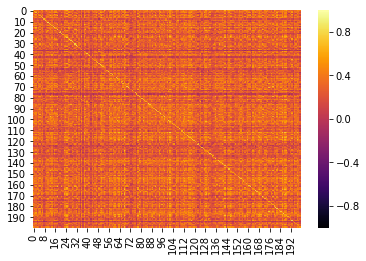

In [147]:
sns.heatmap(title_abstract_cos.cpu(), vmin = -1, vmax = 1, cmap="inferno")

In [148]:
corr = 0

for i in range(n):
    a = torch.argmax(title_abstract_cos[i])
    #print(a, "  :  ", i)
    #print(a - i)
    if (a-i) == 0:
        corr += 1
print(corr/n)

0.635


In [151]:
import csv
import os
import json
from collections import defaultdict

path_metadata = "C:/Users/User/OneDrive - NTNU/NTNU/Prosjekt oppgave NLP/dataset/CORD-19/metadata/metadata.csv

cord_uid_to_text = defaultdict(list)

# open the file
with open(path_metadata) as f_in:
    reader = csv.DictReader(f_in)
    for row in reader:
    
        # access some metadata
        cord_uid = row['cord_uid']
        title = row['title']
        abstract = row['abstract']
        authors = row['authors'].split('; ')

        # access the full text (if available) for Intro
        introduction = []
        if row['pdf_json_files']:
            for json_path in row['pdf_json_files'].split('; '):
                with open(json_path) as f_json:
                    full_text_dict = json.load(f_json)
                    
                    # grab introduction section from *some* version of the full text
                    for paragraph_dict in full_text_dict['body_text']:
                        paragraph_text = paragraph_dict['text']
                        section_name = paragraph_dict['section']
                        if 'intro' in section_name.lower():
                            introduction.append(paragraph_text)

                    # stop searching other copies of full text if already got introduction
                    if introduction:
                        break

        # save for later usage
        cord_uid_to_text[cord_uid].append({
            'title': title,
            'abstract': abstract,
            'introduction': introduction
        })

SyntaxError: EOL while scanning string literal (<ipython-input-151-d657e2338086>, line 6)